# Dashboard

In [219]:
# export
import os
import re
import numpy as np
import pandas as pd
import panel as pn
pn.extension('plotly')

import pyteomics.fasta
from io import StringIO
import plotly.graph_objects as go

from pepmap.importing import import_data
from pepmap.preprocessing import format_input_data
from pepmap.sequenceplot import plot_peptide_traces
from pepmap.uniprot_integration import uniprot_feature_dict
from pepmap.sequenceplot import uniprot_color_dict

In [220]:
path_to_folder_fasta_files = 'data'
full_fasta = None
full_uniprot = None
ac_gene_conversion = None

### Style of the dashboard

In [221]:
#export
css = '''

.bk-root .bk-btn-default.bk-active {
    background-color: #AECCE6;
}

.bk.accordion {
    font-size: smaller;
}

.bk-root .bk-btn {
    padding: 6px 0px 6px 0px;
}

.bk.uniprot_options {
    margin: 17px 6px 12px 6px;
    background-color: white;
    font-size: 13px;
    font-weight: initial;
    text-align: center;
    height: 55px;
    border: 1px solid #e0e0e0;
    border-radius: 2px;
}

.bk-root .bk-btn-primary {
    background-color: #045082;
    font-size: 11px;
    font-weight: 700;
    text-transform: uppercase;
    letter-spacing: 1.5px;
}

.bk.card-title {
    font-size: 13px;
    font-weight: initial;
}

h1 {
    color: #045082;
    font-size: 45px;
    line-height: 0.6;
    text-align: center;
}

h4 {
    color: #173245;
    font-size: 18px;
    line-height: 0.6;
    text-align: center;
}

.codehilite {
    color: #173245;
    font-size: 14px;
    background-color: #eaeaea;
}

.codehilite .s2 {
    color: #173245;
    font-weight: bold;
}

.codehilite .ow {
    color: #045082;
    font-weight: initial;
}

.bk.opt {
    position: relative;
    display: block;
    left: 75px;
    top: 0px;
    width: 80px;
    height: 80px;
}

.bk.main-part {
    background-color: #EAEAEA;
    font-size: 17px;
    line-height: 23px;
    letter-spacing: 0px;
    font-weight: 500;
    color: #045082;
    text-align: center;
    position: relative !important;
    margin-left: auto;
    margin-right: auto;
    width: 40%;
}

.bk.selection_box {
    background-color: #EAEAEA;
}

'''
pn.extension(raw_css=[css])

### Header

In [222]:
### HEADER
header_titel = pn.pane.Markdown(
    '# AlphaMap', 
    width=1250,
    css_classes=['main_header']
)
divider = pn.pane.HTML(
    '<hr style="height: 2px; border:none; background-color: #045082; width: 1480px">', 
    width=1500, 
    align='center'
)
mpi_biochem_logo = pn.pane.PNG(
    'data/img/mpi_logo.png', 
    link_url='https://www.biochem.mpg.de/en', 
    width=60, 
    height=60,
    align='start'
)
mpi_logo = pn.pane.JPG(
    'data/img/max-planck-gesellschaft.jpg', 
    link_url='https://www.biochem.mpg.de/en',
    height=62,
    embed=True,
    width=62,
    margin=(5, 0, 0, 5),
    css_classes=['opt']
)
header = pn.Row(
    mpi_biochem_logo,
    mpi_logo,
    header_titel,
    height=70
)

In [257]:
### WIDGETS

#####################################
# SELECTORS
select_protein = pn.widgets.AutocompleteInput(
    name='Select a Uniprot accession number:', 
    placeholder='Type first letters ...',
    min_characters=1
)
select_organism = pn.widgets.Select(
    name='Select an organism:', 
    value='Human', 
    options=['Human', 'Mouse', 'Arabidopsis'],
    align='center',
    margin=(0,0,0,7),
    width=300
)

#####################################
# CHECKBOXES
is_gene = pn.widgets.Checkbox(
    name='Search by a gene name'
)
select_all = pn.widgets.Checkbox(
    name='Select all options', 
    width=150
)
clear_all = pn.widgets.Checkbox(
    name='Clear all options',
    width=150
)

#####################################
# TEXT
upload_file_text = pn.pane.Markdown(
    'Upload an experimental file:',
    margin=(35,0,-5,10)
)
upload_file_text_inside_card = pn.pane.Markdown(
    'Upload an experimental file:',
    margin=(25,0,-5,10)
)
#####################################
# RAW EXPERIMENTAL DATA
# first experimental file
experimental_data = pn.widgets.FileInput(
    accept=".csv, .txt, .tsv", 
    margin=(-5,-30,20,15)
)
experimental_data_sample = pn.widgets.MultiSelect(
    name='Select samples:', 
    disabled=True,
    size=5,
    width=220,
    margin=(20,0,20,-10)
)
experimental_data_sample_name = pn.widgets.TextInput(
    name='Rename samples:', 
    disabled=True,
    width=140,
    margin=(45,0,20,10)
)
# second experimental file
experimental_data_2 = pn.widgets.FileInput(
    accept=".csv, .txt, .tsv", 
    margin=(-5,-30,20,15)
)
experimental_data_2_sample = pn.widgets.MultiSelect(
    name='Select samples:', 
    size=5,
    disabled=True,
    width=220,
    margin=(10,0,5,-10)
)
experimental_data_2_sample_name = pn.widgets.TextInput(
    name='Rename samples:', 
    disabled=True,
    width=140,
    margin=(35,0,5,10)
)
# third experimental file
experimental_data_3 = pn.widgets.FileInput(
    accept=".csv, .txt, .tsv", 
    margin=(-5,-30,20,15)
)
experimental_data_3_sample = pn.widgets.MultiSelect(
    name='Select samples:', 
    size=5,
    disabled=True,
    width=220,
    margin=(10,0,5,-10)
)
experimental_data_3_sample_name = pn.widgets.TextInput(
    name='Rename samples:', 
    disabled=True,
    width=140,
    margin=(35,0,5,10)
)

#####################################
# PREPROCESSED EXPERIMENTAL DATA
preprocessed_exp_data = pn.widgets.DataFrame(
    name='Exp_data'
)
preprocessed_exp_data_2 = pn.widgets.DataFrame(
    name='Exp_data_2'
)
preprocessed_exp_data_3 = pn.widgets.DataFrame(
    name='Exp_data_3'
)

#####################################
# BUTTONS
upload_button = pn.widgets.Button(
    name='Upload  Data', 
    button_type='primary', 
    css_classes=['button_options'],
    height=40,
    width=150,
    align='center',
    margin=(0,0,0,0)
)
upload_spinner = pn.indicators.LoadingSpinner(
    value=False,
    bgcolor='light',
    color='secondary',
    align='center',
    margin=(0,0,20,0),
    width=50, 
    height=50
)
visualize_button = pn.widgets.Button(
    name='Visualize  Data', 
    button_type='primary', 
    css_classes=['button_options'],
    height=40,
    width=150,
    align='center',
    margin=(0,0,0,18)
)
visualize_spinner = pn.indicators.LoadingSpinner(
    value=False,
    bgcolor='light',
    color='secondary',
    align='center',
    margin=(0,0,20,0),
    width=50, 
    height=50
)

In [224]:
### UNIPROT OPTIONS
options_preprocessing_events = pn.widgets.CheckButtonGroup(
    name='Molecule processing', 
    value=['Chain', 'Initiator methionine', 'Peptide', 'Propeptide', 'Signal peptide', 'Transit peptide'], 
    options=['Chain', 'Initiator methionine', 'Peptide', 'Propeptide', 'Signal peptide', 'Transit peptide'],
    align='center'
)
options_PTMs = pn.widgets.CheckButtonGroup(
    name='Post-translational modification', 
    options=['Cross-link', 'Disulfide bond', 'Glycosylation', 'Lipidation', 'Modified residue'],
    value=['Cross-link', 'Disulfide bond', 'Glycosylation', 'Lipidation', 'Modified residue'],
    align='center'
)
options_domains = pn.widgets.CheckButtonGroup(
    name='Family & Domain',  
    options=['Coiled coil', 'Compositional bias', 'Domain', 'Motif', 'Region', 'Repeat', 'Zinc finger'],
    value=['Coiled coil', 'Compositional bias', 'Domain', 'Motif', 'Region', 'Repeat', 'Zinc finger'],
    align='center'
)
options_locations = pn.widgets.CheckButtonGroup(
    name='Subcellular location', 
    options=['Intramembrane', 'Topological domain', 'Transmembrane'],
    value=['Intramembrane', 'Topological domain', 'Transmembrane'],
    align='center'
)
options_functions = pn.widgets.CheckButtonGroup(
    name='Function', 
    options=['Active site', 'Binding site', 'Calcium binding', 'DNA binding', 'Metal binding', 'Nucleotide binding', 'Site'],
    value=['Active site', 'Binding site', 'Calcium binding', 'DNA binding', 'Metal binding', 'Nucleotide binding', 'Site'],
    align='center'
)
options_sequences = pn.widgets.CheckButtonGroup(
    name='Sequence', 
    options=['Alternative sequence', 'Natural variant', 'Non-adjacent residues', 'Non-standard residue', 
             'Non-terminal residue', 'Sequence conflict', 'Sequence uncertainty'],
    value=['Alternative sequence', 'Natural variant', 'Non-adjacent residues', 'Non-standard residue', 
             'Non-terminal residue', 'Sequence conflict', 'Sequence uncertainty'],
    align='center'
)
options_other = pn.widgets.CheckButtonGroup(
    name='Other options', 
    options=['Secondary structure', 'Mutagenesis'],
    value=['Secondary structure', 'Mutagenesis'],
    align='center'
)

#####################################
### LAYOUTS
uniprot_options = pn.Accordion(
    options_preprocessing_events, 
    options_PTMs,
    options_domains,
    options_locations,
    options_functions,
    options_sequences,
    options_other,
    active=list(range(0,7)),
    header_background='EAEAEA',
    active_header_background='EAEAEA',
    width = 850
)

uniprot_options_tab = pn.Card(
    uniprot_options,
    pn.Row(
        select_all,
        clear_all, 
        margin=5
    ),
    title='Uniprot Options',
    collapsed=True,
    header_background='EAEAEA',
    active_header_background='EAEAEA',
    width=860,
    css_classes=['uniprot_options'],
)

additional_data_card = pn.Card(
    pn.Row(
        pn.Column(
            upload_file_text_inside_card,
            experimental_data_2
        ),
        experimental_data_2_sample,
        experimental_data_2_sample_name
    ),
    pn.Row(
        pn.Column(
            upload_file_text_inside_card,
            experimental_data_3
        ),
        experimental_data_3_sample,
        experimental_data_3_sample_name
    ),
    title='Upload additional experimental files',
    collapsed=True,
    width=640,
    css_classes=['add_experim_options']
)

In [225]:
### MAIN PART
project_description = pn.pane.Markdown(
    """### This website enables the exploration of proteomic datasets on the peptide level. You can evaluate the sequence coverage of any selected protein and its identified post-translational modifications (PTMs). UniProt information is available to directly annotate sequence regions of interest such as protein domains, secondary structures, sequence variants, known PTMs, etc. """,
    margin=(10, 0, -20, 0), 
    css_classes=['main-part'], 
    width=615
)

divider_descr = pn.pane.HTML(
    '<hr style="height: 8px; border:none; background-color: #045082; width: 620px">', 
    width=1510, 
    align='center'
)

project_instuction = pn.pane.Markdown(
    """#### How to use AlphaMap:
    1. Select the organism of your proteomic study.  
    2. Select up to 3 different bottom-up proteomic datasets analyzed  
    by AlphaPept, MaxQuant or Spectronaut.  
    3. Press the "Upload Data" button.  
    4. Select a protein of interest.  
    5. Select desired UniProt sequence annotations.  
    6. Press the "Visualize Data" button.  
    7. Enjoy exploring your data!  
    """,
    width=500,
    align='start',
    margin=(10, 80, 0, 10)
)

spectronaut_description = pn.pane.Markdown(
    """
    The data needs to be exported in the **normal long** format as .tsv or .csv file. 
    
    It needs to include the following columns:  
    >- PEP.AllOccurringProteinAccessions  
    >- EG.ModifiedSequence  
    >- R.FileName  
    
    To ensure the correct export format from Spectronaut, you can download and  
    apply the provided export scheme “spectronaut_export_scheme.rs”.
    """,
    width=500,
    align='start',
    margin=(0, 80, 0, 20)
)

spectronaut_scheme = pn.widgets.FileDownload(
    file='data/spectronaut_export_scheme.rs',
    filename='spectronaut_export_scheme.rs',
    button_type='default', 
    auto=True,
    css_classes=['button_options'],
)

maxquant_description = pn.pane.Markdown(
    """
    To visualize the proteins which were analyzed by the MaxQuant software please use the **evidence.txt** file.

    The following columns from the file are used for visualization:
    >- Proteins
    >- Modified sequence
    >- Raw file
    """,
    width=500,
    align='start',
    margin=(0, 80, 0, 20)
)

spectronaut_instructions = pn.Card(
    spectronaut_description,
    spectronaut_scheme,
    title='Spectronaut instructions',
    collapsed=True,
    width=505,
    align='start',
    margin=(0, 80, 5, 10),
    css_classes=['spectronaut_instr']
)

maxquant_instructions = pn.Card(
    maxquant_description,
    title='MaxQuant instructions',
    collapsed=True,
    width=505,
    align='start',
    margin=(0, 80, 5, 10),
    css_classes=['spectronaut_instr']
)

selection_box = pn.Column(
    select_organism,
    pn.Row(
        pn.Column(
            upload_file_text,
            experimental_data
        ),
        experimental_data_sample,
        experimental_data_sample_name
    ),
    additional_data_card,
    margin=(20, 150, 10, 80),
    width=500,
    css_classes=['selection_box'],
)

main_part = pn.Column(
    project_description,
    divider_descr,
    pn.Row(
        pn.Column(
            project_instuction,
            spectronaut_instructions, 
            maxquant_instructions
        ),
        selection_box,
        align='center'
    ),
    upload_button,
    upload_spinner,
    background='#eaeaea',
    width=1510,
    margin=(5, 0, 10, 0)
)

In [235]:
### PREPROCESSING
def upload_experimental_data():
    global ac_gene_conversion
    if experimental_data_sample.value == ['All samples']:
        data_samples = None
    else:
        data_samples = experimental_data_sample.value
    preprocessed_exp_data.value = format_input_data(
        df = import_data(
            experimental_data.value, 
            dashboard=True, 
            verbose=False, 
            sample=data_samples
        ), 
        fasta = full_fasta, 
        modification_exp = r'\[.*?\]', 
        verbose = False)
    all_unique_proteins = preprocessed_exp_data.value.unique_protein_id.unique().tolist()
    if experimental_data_2.filename:
        if experimental_data_2_sample.value == ['All samples']:
            data_2_samples = None
        else:
            data_2_samples = experimental_data_2_sample.value
        preprocessed_exp_data_2.value = format_input_data(
            df = import_data(
                experimental_data_2.value, 
                dashboard=True, 
                verbose=False,
                sample=data_2_samples
            ), 
            fasta = full_fasta, 
            modification_exp = r'\[.*?\]', 
            verbose = False)
        all_unique_proteins.extend(preprocessed_exp_data_2.value.unique_protein_id.unique().tolist())
    if experimental_data_3.filename:
        if experimental_data_3_sample.value == ['All samples']:
            data_3_samples = None
        else:
            data_3_samples = experimental_data_3_sample.value
        preprocessed_exp_data_3.value = format_input_data(
            df = import_data(
                experimental_data_3.value, 
                dashboard=True, 
                verbose=False,
                sample=data_3_samples
            ), 
            fasta = full_fasta, 
            modification_exp = r'\[.*?\]', 
            verbose = False)
        all_unique_proteins.extend(preprocessed_exp_data_3.value.unique_protein_id.unique().tolist())
    select_protein.options = sorted(list(set(all_unique_proteins)))
    ac_gene_conversion = {
        each: f"{full_fasta.get_by_id(each).description.get('GN')} ({full_fasta.get_by_id(each).description.get('id')})" \
        for each in select_protein.options}
    
def upload_organism_info():
    global full_fasta, full_uniprot
    if select_organism.value == 'Human':
        fasta_name = "human.fasta"
        uniprot_name = "preprocessed_uniprot_human.csv"
    elif select_organism.value == 'Mouse':
        fasta_name = "mouse.fasta"
        uniprot_name = "preprocessed_uniprot_mouse.csv"
    elif select_organism.value == 'Arabidopsis':
        fasta_name = "arabidopsis_thaliana.fasta"
        uniprot_name = "preprocessed_uniprot_arabidopsis.csv"
    full_fasta = pyteomics.fasta.IndexedUniProt(os.path.join(path_to_folder_fasta_files, fasta_name))
    full_uniprot = pd.read_csv(os.path.join(path_to_folder_fasta_files, uniprot_name))
    

def extract_samples(data):
    """
    Extract information about unique sample names that present in the raw file analyzed by MaxQuant or Spectronaut.
    """
    sample_columns = ['R.FileName', 'Raw file']
    unique_samples = pd.read_csv(StringIO(str(data, "utf-8")), sep=None, engine='python', 
            usecols=lambda col: col in sample_columns).iloc[:, 0].unique().tolist()
    return unique_samples

def extract_name(filename, sample, sample_name):
    if sample_name:
        name = sample_name
    elif sample and sample != 'All samples':
        name = sample
    else:
        name = filename.split('.')[0]
    return name

@pn.depends(
    experimental_data.param.value, 
    watch=True
)
def update_data_sample_info(data1):
    experimental_data_sample.disabled = False
    experimental_data_sample.options = ['All samples'] + extract_samples(data1) 
    experimental_data_sample.value = ['All samples']

@pn.depends(
    experimental_data_2.param.value,
    watch=True
)
def update_data_2_sample_info(data2):
    experimental_data_2_sample.disabled = False
    experimental_data_2_sample.options = ['All samples'] + extract_samples(data2) 
    experimental_data_2_sample.value = ['All samples']

    
@pn.depends(
    experimental_data_3.param.value,
    watch=True
)
def update_data_3_sample_info(data3):
    experimental_data_3_sample.disabled = False
    experimental_data_3_sample.options = ['All samples'] + extract_samples(data3) 
    experimental_data_3_sample.value = ['All samples']
    
    
@pn.depends(
    experimental_data_sample.param.value,
    experimental_data_2_sample.param.value,
    experimental_data_3_sample.param.value,
    watch=True
)
def change_sample_name_state(data_sample, data_2_sample, data_3_sample):
    if data_sample and data_sample != ['All samples']:
        experimental_data_sample_name.disabled = False
    else:
        experimental_data_sample_name.disabled = True
    if data_2_sample and data_2_sample != ['All samples']:
        experimental_data_2_sample_name.disabled = False
    else:
        experimental_data_2_sample_name.disabled = True
    if data_3_sample and data_3_sample != ['All samples']:
        experimental_data_3_sample_name.disabled = False 
    else:
        experimental_data_3_sample_name.disabled = True

@pn.depends(
    select_all.param.value,
    clear_all.param.value,
    watch=True
)
def change_uniprot_selection(select, clear):
    if select:
        clear_all.value = False
        for each in uniprot_options.objects:
            each.value = each.options
    if clear:
        select_all.value = False
        for each in uniprot_options.objects:
            each.value = []
        
        
@pn.depends(
    is_gene.param.value, 
    watch=True
)
def change_autocomplete_input(is_gene):
    if experimental_data.filename:
        if is_gene:
            select_protein.options = list(ac_gene_conversion.values())
        else:
            select_protein.options = list(ac_gene_conversion.keys())


In [252]:
### VISUALIZATION
@pn.depends(
    upload_button.param.clicks
)
def upload_data(clicks):
    if clicks > 0:
        upload_spinner.value = True
        select_protein.value = None
        # preload the data
        upload_organism_info()
        upload_experimental_data()
        # create a layout
        app = pn.Column(
            pn.Row(
                pn.layout.VSpacer(width=100),
                pn.Column(
                    select_protein,
                    is_gene
                ),
                pn.layout.VSpacer(width=80),
                uniprot_options_tab,
                aligh='center'
            ),
            pn.layout.HSpacer(height=10),
            visualize_button,
            visualize_spinner,
            divider,
            pn.Pane(
                visualize_plot, 
                config={'toImageButtonOptions': 
                           {'format': 'svg', # one of png, svg, jpeg, webp
                            'filename': 'custom_image',
                            'height': 500,
                            'width': 1500,
                            'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
                           }
                       }, 
                aligh='center', 
                width=1500
            ),
            margin=(20, 0)
        )
        upload_spinner.value = False
        return app
    
    
@pn.depends(visualize_button.param.clicks)
def visualize_plot(_):
    if select_protein.value:
        visualize_spinner.value = True
        # combine selected uniprot options in one list
        uniprot_options_combined = sum([each.value for each in uniprot_options.objects if each.value], [])
        # extract all experimental data and names 
        all_data = []
        all_names = []
        if experimental_data.filename:
            all_data.append(preprocessed_exp_data.value)
            all_names.append(
                extract_name(experimental_data.filename, 
                             experimental_data_sample.value, 
                             experimental_data_sample_name.value
                )
            )
        if experimental_data_2.filename:
            all_data.append(preprocessed_exp_data_2.value)
            all_names.append(
                extract_name(experimental_data_2.filename, 
                             experimental_data_2_sample.value, 
                             experimental_data_2_sample_name.value
                )
            )
        if experimental_data_3.filename:
            all_data.append(preprocessed_exp_data_3.value)
            all_names.append(
                extract_name(experimental_data_3.filename, 
                             experimental_data_3_sample.value, 
                             experimental_data_3_sample_name.value
                )
            )
        # if only one experimental file is uploaded we need to return a string for input into plot_peptide_traces
        if len(all_data) == 1:
            all_data = all_data[0]
            all_names = all_names[0]
        if is_gene.value:
            selected_protein = re.findall(r"\((?P<id>.+?)\)", select_protein.value)[0]
        else:
            selected_protein = select_protein.value
        # create a main figure
        fig =  plot_peptide_traces(
            df = all_data,
            name = all_names,
            protein = selected_protein,
            fasta = full_fasta, 
            uniprot = full_uniprot,
            selected_features = [uniprot_feature_dict[each] for each in uniprot_options_combined],
            uniprot_feature_dict = uniprot_feature_dict, 
            uniprot_color_dict = uniprot_color_dict)
        visualize_spinner.value = False
        return fig
    else:
        return None

In [228]:
### JS callbacks to control the behaviour of pn.Cards
uniprot_options_tab.jscallback(
    collapsed=""" 
        var $container = $("html,body");
        var $scrollTo = $('.uniprot_options');

        $container.animate({scrollTop: $container.offset().top + $container.scrollTop(), scrollLeft: 0},300);
        """, 
    args={'card': uniprot_options_tab}
);

additional_data_card.jscallback(
    collapsed=""" 
        var $container = $("html,body");
        var $scrollTo = $('.add_experim_options');

        $container.animate({scrollTop: $container.offset().top + $container.scrollTop(), scrollLeft: 0},300);
        """, 
    args={'card': additional_data_card}
);

spectronaut_instructions.jscallback(
    collapsed=""" 
        var $container = $("html,body");
        var $scrollTo = $('.spectronaut_instr');

        $container.animate({scrollTop: $container.offset().top + $container.scrollTop(), scrollLeft: 0},300);
        """, 
    args={'card': spectronaut_instructions}
);

maxquant_instructions.jscallback(
    collapsed=""" 
        var $container = $("html,body");
        var $scrollTo = $('.spectronaut_instr');

        $container.animate({scrollTop: $container.offset().top + $container.scrollTop(), scrollLeft: 0},300);
        """, 
    args={'card': maxquant_instructions}
);

In [236]:
layout = pn.Column(
    header,
    main_part,
    upload_data
)

Column
    [0] Row(height=70)
        [0] PNG(str, height=60, link_url='https://www.biochem.mpg.d..., sizing_mode='fixed', width=60)
        [1] JPG(str, css_classes=['opt'], height=62, link_url='https://www.biochem.mpg.d..., margin=(5, 0, 0, 5), sizing_mode='fixed', width=62)
        [2] Markdown(str, css_classes=['main_header'], width=1250)
    [1] Column(background='#eaeaea', margin=(5, 0, 10, 0), width=1510)
        [0] Markdown(str, css_classes=['main-part'], margin=(10, 0, -10, 0), width=615)
        [1] HTML(str, align='center', width=1510)
        [2] Row(align='center')
            [0] Column
                [0] Markdown(str, margin=(10, 80, 0, 10), width=500)
                [1] Card(collapsed=True, css_classes=['spectronaut_instr'], margin=(0, 80, 10, 10), title='Spectronaut I..., width=505)
                    [0] Markdown(str, margin=(0, 80, 0, 20), width=500)
                    [1] FileDownload(css_classes=['button_options'], file='data/spectronaut_export_s..., filename='spectronaut_export_scheme..., label='Download spectronaut_expo...)
            [1] Column(css_classes=['selection_box'], margin=(20, 150, 10, 80), width=500)
                [0] Select(align='center', margin=(0, 0, 0, 7), options=['Human', 'Mouse', ...], value='Human', width=300)
                [1] Row
                    [0] Column
                        [0] Markdown(str, margin=(10, 0, -5, 10))
                        [1] FileInput(accept='.csv, .txt, .tsv', filename='test_spectronaut_input.cs..., margin=(-5, 0, 20, 15), mime_type='application/vnd.ms-excel'..., value=b'R.FileName,P...)
                    [1] Select(margin=(20, 0, 20, 5), options=['All samples', ...], value='All samples', width=200)
                    [2] TextInput(margin=(20, 0, 20, 5), name='Rename a sample:', width=120)
                [2] Card(collapsed=True, css_classes=['add_experim_options'], title='Upload additional e..., width=640)
                    [0] Row
                        [0] Column
                            [0] Markdown(str, margin=(-3, 0, -5, 10))
                            [1] FileInput(accept='.csv, .txt, .tsv', margin=(-5, 0, 20, 15))
                        [1] Select(disabled=True, margin=(10, 0, 5, 5), width=200)
                        [2] TextInput(disabled=True, margin=(10, 0, 5, 5), name='Rename a sample:', width=120)
                    [1] Row
                        [0] Column
                            [0] Markdown(str, margin=(-3, 0, -5, 10))
                            [1] FileInput(accept='.csv, .txt, .tsv', margin=(-5, 0, 20, 15))
                        [1] Select(disabled=True, margin=(10, 0, 5, 5), width=200)
                        [2] TextInput(disabled=True, margin=(10, 0, 5, 5), name='Rename a sample:', width=120)
        [3] Button(align='center', button_type='primary', css_classes=['button_options'], height=40, margin=(0, 0, 10, 0), name='Upload  Data', sizing_mode='fixed', width=150)
        [4] LoadingSpinner(align='center', color='secondary', height=50, margin=(0, 0, 30, 0), width=50)
    [2] ParamFunction(function)
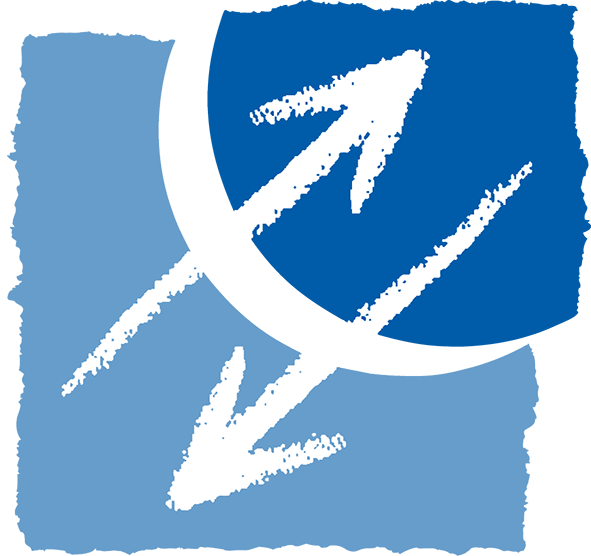
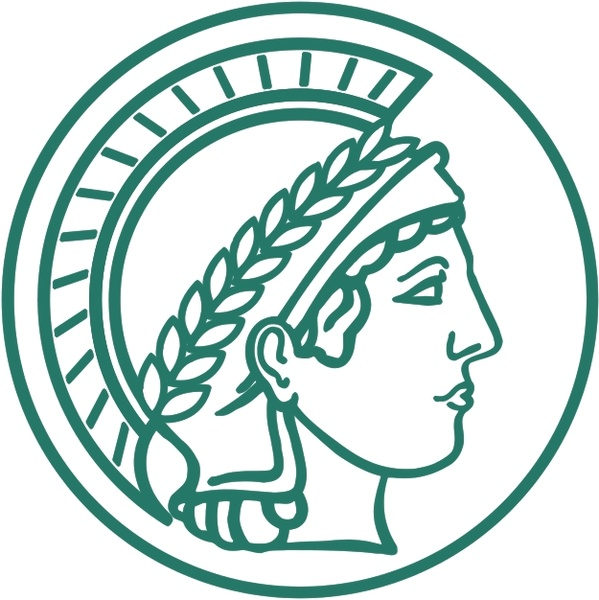

In [237]:
layout.servable()